Dataset Overview:
Total records: 2439
Unique subjects: 481
Visit types: ['bl', 'm06', 'm12', 'm138', 'm18', 'm24', 'm30', 'm36', 'm42', 'm48', 'm54', 'm60', 'm66', 'm72', 'm78', 'm84', 'm90', 'm96']
Research groups: {'MCI': 1752, 'AD': 687}
Age range: 55.2 - 90.9 years
Preparing data for analysis...
Processed 2439 records
Found 481 patients with trajectory data

Running comprehensive analysis...

Performing descriptive analysis...
Total patients: 481
Total visits: 2439
Average visits per patient: 5.07
Time points: [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 138]
Score statistics:
count    2439.000000
mean       24.260644
std        11.751440
min         0.000000
25%        16.330000
50%        23.000000
75%        31.000000
max        85.000000
Name: TOTAL13, dtype: float64

Visualizing trajectories (sample of 50 patients)...


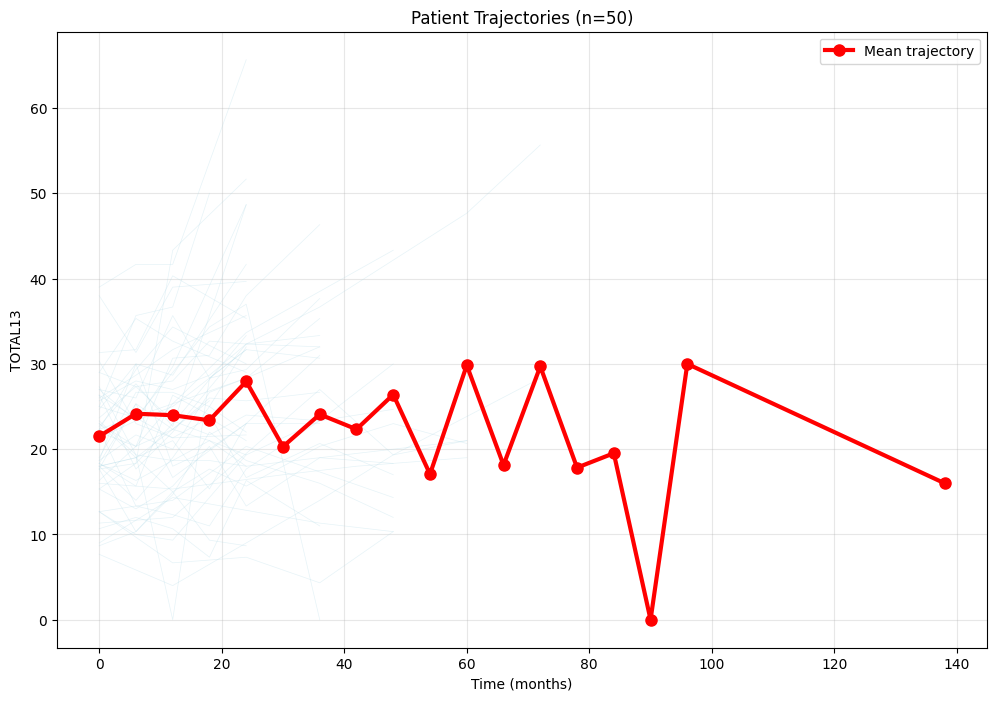


Performing trajectory clustering with 3 clusters...
No complete trajectories found for clustering

Performing mixed effects analysis...
Fixed Effects:
  Mean intercept: 21.209
  Mean slope: 0.252
  Slope variability (SD): 0.450

Performing time series decomposition...
Overall trend slope: -0.0633 points per month


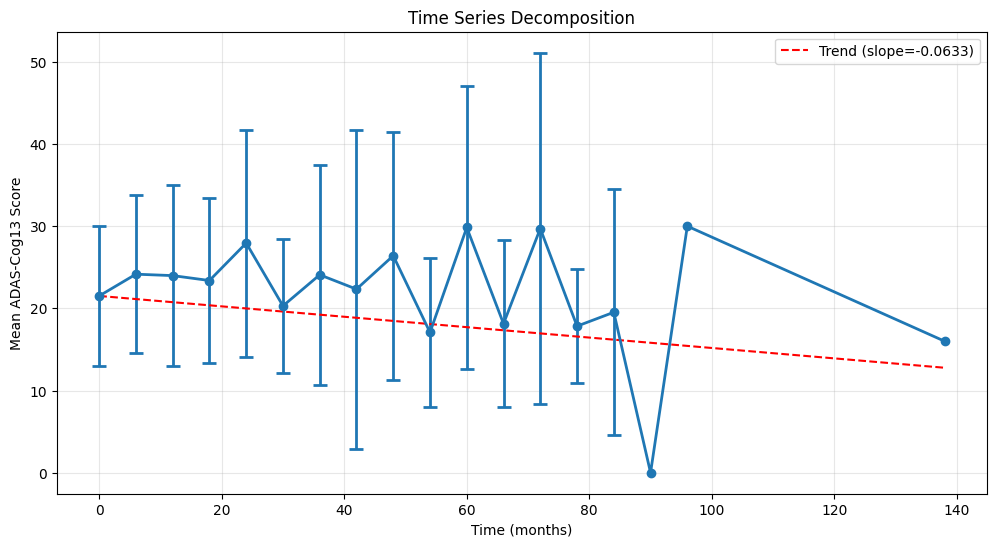


Forecasting for patient 002_S_0619...
Forecasted next 3 visits:
  Month 30.0: 42.43
  Month 36.0: 44.35
  Month 42.0: 46.28

COMPREHENSIVE ANALYSIS REPORT
Dataset Overview:
- Total patients: 481
- Total visits: 2439
- Average visits per patient: 5.07
- Time points: [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 138]

Progression Analysis:
- Mean progression rate: 0.2518 points/month
- Progression rate SD: 0.4494
- Patients with worsening: 382 (79.4%)

Population Effects:
- Mean baseline score: 21.21
- Mean progression rate: 0.2518 points/month
- Individual variability: 0.4499


=== Analysis by Research Group ===
ADAS-Cog13 scores by group and visit:
                             count   mean    std
research_group visit_months                     
AD             0               168  27.86   8.06
               6               164  29.56   9.68
               12              166  31.68  10.87
               24              163  35.87  14.45
               30          

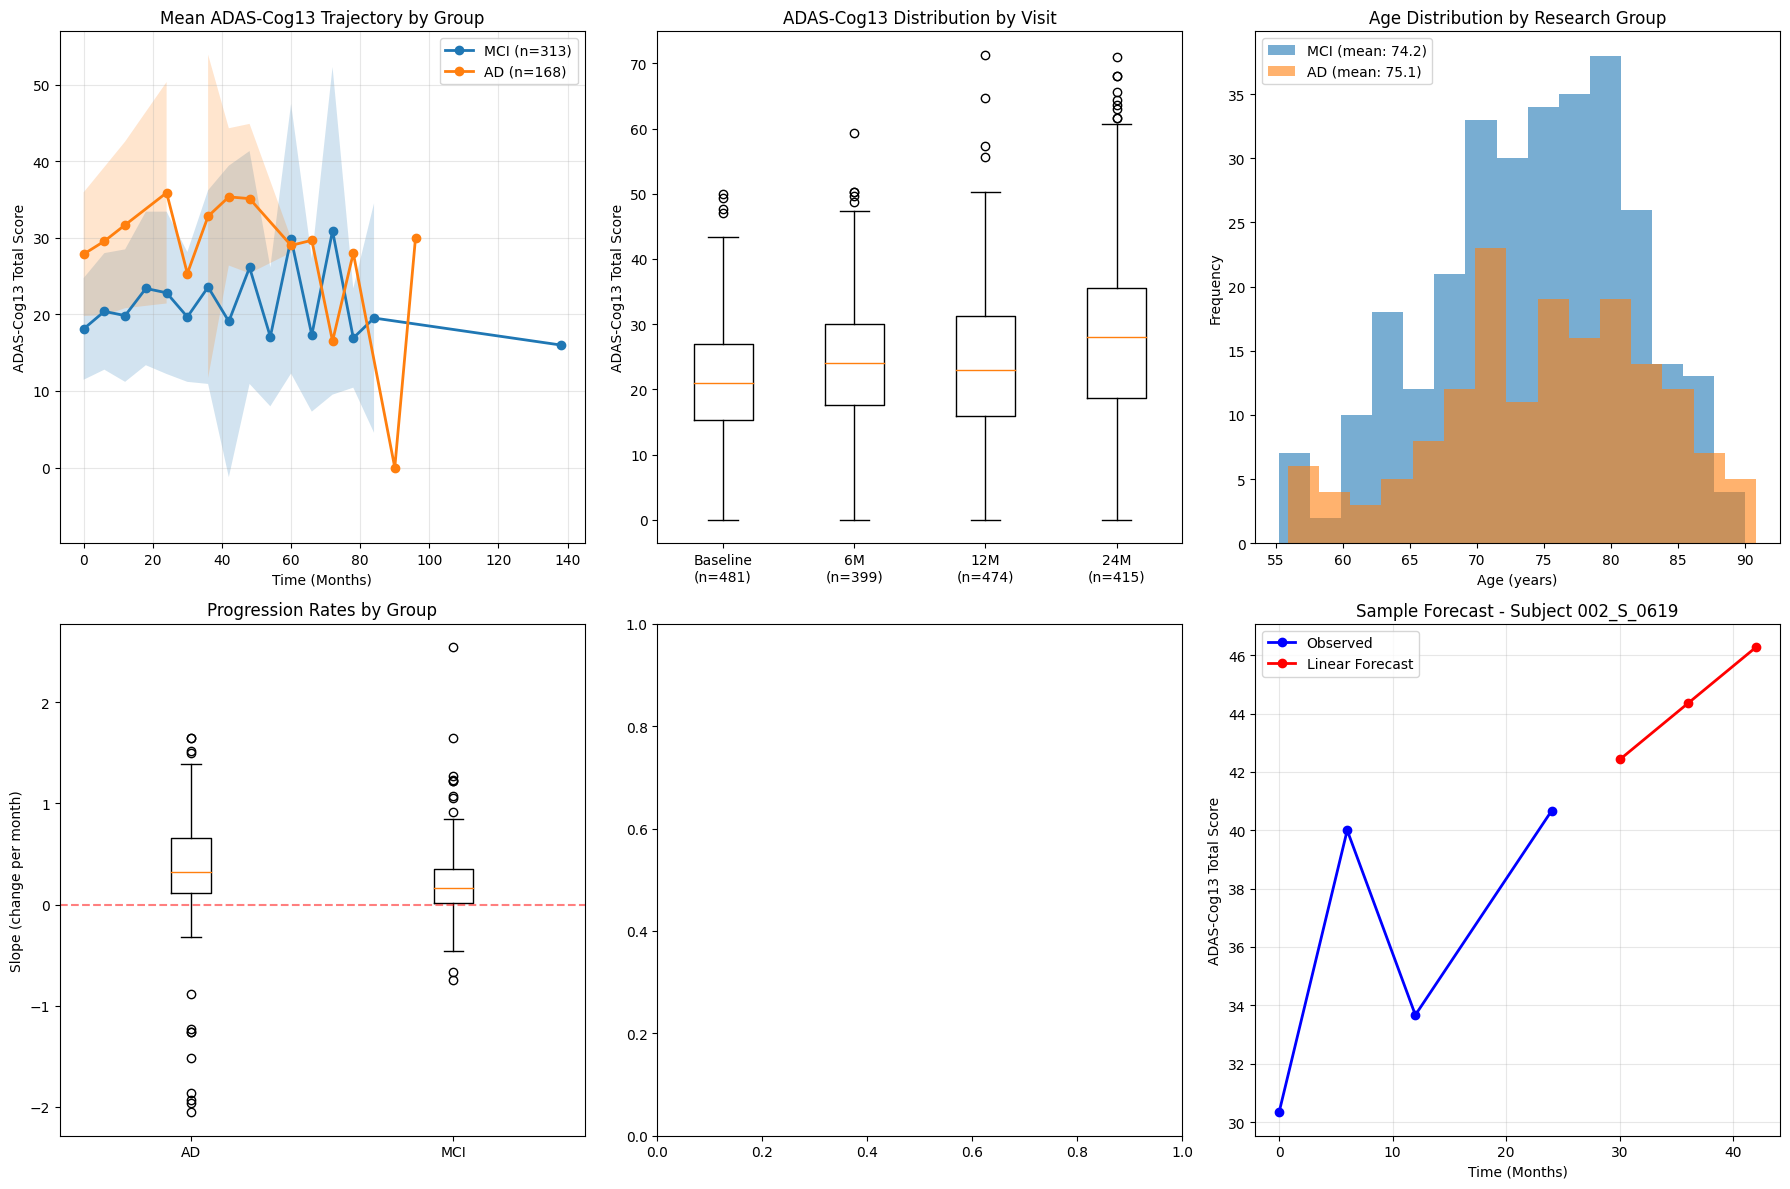


Key Findings:
- AD subjects: 168
- MCI subjects: 313
- Average AD score at baseline: 27.86
- Average MCI score at baseline: 18.10
- Average progression rate: 0.2518 points per month
- Subjects with worsening scores: 382 (79.4%)
- Check 'analyzed_results.csv' for detailed data with group information


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class NeuroTimeSeriesAnalyzer:
    def __init__(self, data=None):
        self.data = data
        self.processed_data = None
        self.results = {}
    
    def load_and_prepare_data(self, patient_col, time_col, score_col):
        print("Preparing data for analysis...")
        
        # Basic data validation
        required_cols = [patient_col, time_col, score_col]
        missing_cols = [col for col in required_cols if col not in self.data.columns]
        if missing_cols:
            raise ValueError(f"Missing columns: {missing_cols}")
        
        # Remove rows with missing values in key columns
        self.processed_data = self.data.dropna(subset=required_cols).copy()
        
        # Sort by patient and time
        self.processed_data = self.processed_data.sort_values([patient_col, time_col])
        
        # Create trajectory matrix for patients with multiple visits
        trajectories = {}
        for patient_id in self.processed_data[patient_col].unique():
            patient_data = self.processed_data[self.processed_data[patient_col] == patient_id]
            if len(patient_data) >= 2:  # At least 2 visits for trajectory
                trajectories[patient_id] = {
                    'times': patient_data[time_col].values,
                    'scores': patient_data[score_col].values
                }
        
        print(f"Processed {len(self.processed_data)} records")
        print(f"Found {len(trajectories)} patients with trajectory data")
        
        return self.processed_data, trajectories
    
    def descriptive_analysis(self, patient_col, time_col, score_col):
        """Perform descriptive analysis"""
        print("\nPerforming descriptive analysis...")
        
        summary = {
            'total_patients': self.processed_data[patient_col].nunique(),
            'total_visits': len(self.processed_data),
            'avg_visits_per_patient': len(self.processed_data) / self.processed_data[patient_col].nunique(),
            'time_points': sorted(self.processed_data[time_col].unique()),
            'score_stats': self.processed_data[score_col].describe()
        }
        
        print(f"Total patients: {summary['total_patients']}")
        print(f"Total visits: {summary['total_visits']}")
        print(f"Average visits per patient: {summary['avg_visits_per_patient']:.2f}")
        print(f"Time points: {summary['time_points']}")
        print(f"Score statistics:\n{summary['score_stats']}")
        
        self.results['descriptive'] = summary
        return summary
    
    def visualize_trajectories(self, patient_col, time_col, score_col, sample_size=50):
        """Visualize patient trajectories"""
        print(f"\nVisualizing trajectories (sample of {sample_size} patients)...")
        
        plt.figure(figsize=(12, 8))
        
        # Sample patients for visualization
        patients = self.processed_data[patient_col].unique()
        if len(patients) > sample_size:
            patients = np.random.choice(patients, sample_size, replace=False)
        
        # Plot individual trajectories
        for i, patient_id in enumerate(patients):
            patient_data = self.processed_data[self.processed_data[patient_col] == patient_id]
            if len(patient_data) >= 2:
                plt.plot(patient_data[time_col], patient_data[score_col], 
                        alpha=0.3, color='lightblue', linewidth=0.5)
        
        # Plot mean trajectory
        mean_trajectory = self.processed_data.groupby(time_col)[score_col].mean()
        plt.plot(mean_trajectory.index, mean_trajectory.values, 
                'ro-', linewidth=3, markersize=8, label='Mean trajectory')
        
        plt.xlabel('Time (months)')
        plt.ylabel(score_col)
        plt.title(f'Patient Trajectories (n={len(patients)})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Calculate change data for analysis
        change_data = []
        slopes = []
        
        for patient_id in self.processed_data[patient_col].unique():
            patient_data = self.processed_data[self.processed_data[patient_col] == patient_id]
            if len(patient_data) >= 2:
                times = patient_data[time_col].values
                scores = patient_data[score_col].values
                
                # Calculate slope using linear regression
                if len(times) > 1:
                    slope = np.polyfit(times, scores, 1)[0]
                    slopes.append(slope)
                    
                    change_data.append({
                        'patient_id': patient_id,
                        'baseline_score': scores[0],
                        'final_score': scores[-1],
                        'total_change': scores[-1] - scores[0],
                        'time_span': times[-1] - times[0],
                        'slope': slope
                    })
        
        self.results['change_analysis'] = {
            'change_data': pd.DataFrame(change_data),
            'slopes': slopes
        }
        
        return pd.DataFrame(change_data)
    
    def trajectory_clustering(self, n_clusters=3):
        """Perform trajectory clustering"""
        print(f"\nPerforming trajectory clustering with {n_clusters} clusters...")
        
        # Create trajectory matrix for clustering
        time_points = sorted(self.processed_data['visit_months'].unique())
        patients_with_complete_data = []
        complete_trajectories = []
        
        for patient_id in self.processed_data['subject_id'].unique():
            patient_data = self.processed_data[self.processed_data['subject_id'] == patient_id]
            
            # Check if patient has data for all time points
            patient_times = set(patient_data['visit_months'].values)
            if len(patient_times.intersection(time_points)) >= 2:  # At least 2 time points
                # Create trajectory vector
                trajectory = []
                for tp in time_points:
                    tp_data = patient_data[patient_data['visit_months'] == tp]
                    if len(tp_data) > 0:
                        trajectory.append(tp_data['TOTAL13'].iloc[0])
                    else:
                        trajectory.append(np.nan)
                
                # Only include if we have at least 50% of time points
                if sum(~np.isnan(trajectory)) >= len(time_points) * 0.5:
                    patients_with_complete_data.append(patient_id)
                    complete_trajectories.append(trajectory)
        
        if len(complete_trajectories) < n_clusters:
            print(f"Warning: Only {len(complete_trajectories)} complete trajectories found, reducing clusters to {len(complete_trajectories)}")
            n_clusters = min(n_clusters, len(complete_trajectories))
        
        if len(complete_trajectories) == 0:
            print("No complete trajectories found for clustering")
            return None, None
        
        # Convert to DataFrame and handle missing values
        traj_df = pd.DataFrame(complete_trajectories, columns=time_points)
        traj_df = traj_df.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
        
        # Standardize trajectories
        scaler = StandardScaler()
        traj_scaled = scaler.fit_transform(traj_df)
        
        # Perform clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(traj_scaled)
        
        # Calculate cluster summary
        cluster_summary = []
        for cluster_id in range(n_clusters):
            cluster_data = traj_df.iloc[cluster_labels == cluster_id]
            
            if len(cluster_data) > 0:
                # Calculate mean slope for the cluster
                mean_slopes = []
                for idx in range(len(cluster_data)):
                    row = cluster_data.iloc[idx].dropna()
                    if len(row) >= 2:
                        times = [time_points[i] for i in range(len(time_points)) if i < len(row)]
                        scores = row.values[:len(times)]
                        if len(times) == len(scores) and len(times) >= 2:
                            slope = np.polyfit(times, scores, 1)[0]
                            mean_slopes.append(slope)
                
                summary = {
                    'cluster': cluster_id + 1,
                    'n_patients': len(cluster_data),
                    'baseline_mean': cluster_data.iloc[:, 0].mean(),
                    'baseline_std': cluster_data.iloc[:, 0].std(),
                    'final_mean': cluster_data.iloc[:, -1].mean(),
                    'final_std': cluster_data.iloc[:, -1].std(),
                    'mean_slope': np.mean(mean_slopes) if mean_slopes else 0
                }
                cluster_summary.append(summary)
        
        cluster_summary_df = pd.DataFrame(cluster_summary)
        
        print("\nCluster Characteristics:")
        print(cluster_summary_df)
        
        # Visualize clusters
        plt.figure(figsize=(12, 8))
        colors = ['red', 'blue', 'green', 'orange', 'purple']
        
        for cluster_id in range(n_clusters):
            cluster_data = traj_df.iloc[cluster_labels == cluster_id]
            if len(cluster_data) > 0:
                # Plot individual trajectories
                for idx in range(len(cluster_data)):
                    plt.plot(time_points, cluster_data.iloc[idx], 
                            color=colors[cluster_id], alpha=0.3, linewidth=0.5)
                
                # Plot cluster centroid
                centroid = cluster_data.mean()
                plt.plot(time_points, centroid.values, 
                        color=colors[cluster_id], linewidth=3,
                        label=f'Cluster {cluster_id+1} (n={len(cluster_data)})')
        
        plt.xlabel('Time (months)')
        plt.ylabel('ADAS-Cog13 Score')
        plt.title('Trajectory Clusters')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        self.results['clustering'] = {
            'labels': cluster_labels,
            'complete_trajectories': traj_df,
            'patients': patients_with_complete_data,
            'optimal_k': n_clusters
        }
        
        return cluster_labels, cluster_summary_df
    
    def mixed_effects_analysis(self, patient_col, time_col, score_col):
        """Simple mixed effects analysis approximation"""
        print("\nPerforming mixed effects analysis...")
        
        # Calculate individual slopes and intercepts
        individual_effects = []
        
        for patient_id in self.processed_data[patient_col].unique():
            patient_data = self.processed_data[self.processed_data[patient_col] == patient_id]
            if len(patient_data) >= 2:
                times = patient_data[time_col].values
                scores = patient_data[score_col].values
                
                # Fit linear model
                coeffs = np.polyfit(times, scores, 1)
                slope, intercept = coeffs[0], coeffs[1]
                
                individual_effects.append({
                    'patient_id': patient_id,
                    'slope': slope,
                    'intercept': intercept,
                    'n_visits': len(patient_data)
                })
        
        effects_df = pd.DataFrame(individual_effects)
        
        # Population-level effects
        fixed_effects = {
            'mean_intercept': effects_df['intercept'].mean(),
            'mean_slope': effects_df['slope'].mean(),
            'slope_std': effects_df['slope'].std()
        }
        
        print(f"Fixed Effects:")
        print(f"  Mean intercept: {fixed_effects['mean_intercept']:.3f}")
        print(f"  Mean slope: {fixed_effects['mean_slope']:.3f}")
        print(f"  Slope variability (SD): {fixed_effects['slope_std']:.3f}")
        
        self.results['mixed_effects'] = {
            'individual_effects': effects_df,
            'fixed_effects': fixed_effects
        }
        
        return fixed_effects
    
    def time_series_decomposition(self, patient_col, time_col, score_col):
        """Basic time series analysis"""
        print("\nPerforming time series decomposition...")
        
        # Create aggregate time series
        ts_data = self.processed_data.groupby(time_col)[score_col].agg(['mean', 'std', 'count'])
        
        # Simple trend analysis
        times = ts_data.index.values
        means = ts_data['mean'].values
        
        if len(times) >= 2:
            trend_slope = np.polyfit(times, means, 1)[0]
            
            decomposition = {
                'time_points': times,
                'mean_scores': means,
                'std_scores': ts_data['std'].values,
                'n_subjects': ts_data['count'].values,
                'trend_slope': trend_slope
            }
            
            print(f"Overall trend slope: {trend_slope:.4f} points per month")
            
            # Visualize
            plt.figure(figsize=(12, 6))
            plt.errorbar(times, means, yerr=ts_data['std'].values, 
                        fmt='o-', capsize=5, capthick=2, linewidth=2)
            plt.plot(times, np.polyval([trend_slope, means[0] - trend_slope*times[0]], times), 
                    'r--', label=f'Trend (slope={trend_slope:.4f})')
            plt.xlabel('Time (months)')
            plt.ylabel('Mean ADAS-Cog13 Score')
            plt.title('Time Series Decomposition')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
            self.results['time_series'] = decomposition
            return decomposition
        
        return None
    
    def individual_patient_forecasting(self, patient_id, forecast_periods, patient_col, time_col, score_col):
        """Simple individual patient forecasting"""
        print(f"\nForecasting for patient {patient_id}...")
        
        patient_data = self.processed_data[self.processed_data[patient_col] == patient_id]
        
        if len(patient_data) < 2:
            print("Insufficient data for forecasting")
            return None
        
        times = patient_data[time_col].values
        scores = patient_data[score_col].values
        
        # Fit linear trend
        coeffs = np.polyfit(times, scores, 1)
        slope, intercept = coeffs[0], coeffs[1]
        
        # Generate future time points
        last_time = times[-1]
        time_interval = np.median(np.diff(times)) if len(times) > 2 else 6  # Assume 6-month intervals
        future_times = [last_time + (i+1)*time_interval for i in range(forecast_periods)]
        
        # Linear extrapolation
        linear_forecast = [slope * t + intercept for t in future_times]
        
        forecast = {
            'patient_id': patient_id,
            'historical_times': times,
            'historical_scores': scores,
            'future_times': future_times,
            'linear_forecast': linear_forecast,
            'trend_slope': slope
        }
        
        print(f"Forecasted next {forecast_periods} visits:")
        for t, s in zip(future_times, linear_forecast):
            print(f"  Month {t}: {s:.2f}")
        
        return forecast
    
    def generate_comprehensive_report(self):
        """Generate a comprehensive analysis report"""
        print("\n" + "="*50)
        print("COMPREHENSIVE ANALYSIS REPORT")
        print("="*50)
        
        report = []
        
        if 'descriptive' in self.results:
            desc = self.results['descriptive']
            report.append(f"Dataset Overview:")
            report.append(f"- Total patients: {desc['total_patients']}")
            report.append(f"- Total visits: {desc['total_visits']}")
            report.append(f"- Average visits per patient: {desc['avg_visits_per_patient']:.2f}")
            report.append(f"- Time points: {desc['time_points']}")
            report.append("")
        
        if 'change_analysis' in self.results:
            slopes = self.results['change_analysis']['slopes']
            report.append(f"Progression Analysis:")
            report.append(f"- Mean progression rate: {np.mean(slopes):.4f} points/month")
            report.append(f"- Progression rate SD: {np.std(slopes):.4f}")
            report.append(f"- Patients with worsening: {sum(s > 0 for s in slopes)} ({100*sum(s > 0 for s in slopes)/len(slopes):.1f}%)")
            report.append("")
        
        if 'clustering' in self.results:
            report.append(f"Trajectory Clustering:")
            report.append(f"- Identified {self.results['clustering']['optimal_k']} distinct patterns")
            report.append(f"- {len(self.results['clustering']['patients'])} patients clustered")
            report.append("")
        
        if 'mixed_effects' in self.results:
            fixed = self.results['mixed_effects']['fixed_effects']
            report.append(f"Population Effects:")
            report.append(f"- Mean baseline score: {fixed['mean_intercept']:.2f}")
            report.append(f"- Mean progression rate: {fixed['mean_slope']:.4f} points/month")
            report.append(f"- Individual variability: {fixed['slope_std']:.4f}")
            report.append("")
        
        full_report = "\n".join(report)
        print(full_report)
        
        return full_report

# Load your dataset
data = pd.read_csv('t_final.csv')

# Convert visit codes to numeric months
visit_mapping = {
    'bl': 0,      # baseline
    'm06': 6,     # 6 months
    'm12': 12,    # 12 months
    'm18': 18,    # 18 months (if exists)
    'm24': 24,
    'm30': 30,    # 24 months
    'm36': 36,
    'm42': 42,     # 36 months (if exists)
    'm48': 48,
    'm54': 54, 
    'm60': 60,
    'm66': 66, 
    'm72': 72,
    'm78': 78,
    'm84': 84,
    'm90': 90,
    'm96': 96, 
    'm108': 108,
    'm114': 114, 
    'm120': 120,
    'm138': 138,  
    'm144': 144,   
    'm156': 156
}

data['visit_months'] = data['visit'].map(visit_mapping)

# Remove any unmapped visits
data = data.dropna(subset=['visit_months'])

print("Dataset Overview:")
print(f"Total records: {len(data)}")
print(f"Unique subjects: {data['subject_id'].nunique()}")
print(f"Visit types: {sorted(data['visit'].unique())}")
print(f"Research groups: {data['research_group'].value_counts().to_dict()}")
print(f"Age range: {data['subject_age'].min():.1f} - {data['subject_age'].max():.1f} years")

# Initialize analyzer with processed data
analyzer = NeuroTimeSeriesAnalyzer(data=data)

# Run analysis with your column names
processed_data, trajectories = analyzer.load_and_prepare_data(
    patient_col='subject_id',       # Your subject ID column
    time_col='visit_months',        # Converted numeric time column
    score_col='TOTAL13'             # Your ADAS-Cog13 total score column
)

# Run complete analysis pipeline
print("\nRunning comprehensive analysis...")

# 1. Descriptive statistics
summary = analyzer.descriptive_analysis(
    patient_col='subject_id',
    time_col='visit_months', 
    score_col='TOTAL13'
)

# 2. Visualize trajectories
change_data = analyzer.visualize_trajectories(
    patient_col='subject_id',
    time_col='visit_months',
    score_col='TOTAL13',
    sample_size=50  # Adjust based on your dataset size
)

# 3. Trajectory clustering (fixed)
clusters, cluster_summary = analyzer.trajectory_clustering(n_clusters=3)

# 4. Mixed effects modeling
mixed_results = analyzer.mixed_effects_analysis(
    patient_col='subject_id',
    time_col='visit_months',
    score_col='TOTAL13'
)

# 5. Time series analysis
decomposition = analyzer.time_series_decomposition(
    patient_col='subject_id',
    time_col='visit_months',
    score_col='TOTAL13'
)

# 6. Individual patient forecasting (example)
if len(processed_data) > 0:
    sample_patient = processed_data['subject_id'].iloc[0]
    forecast = analyzer.individual_patient_forecasting(
        patient_id=sample_patient,
        forecast_periods=3,  # Predict next 3 visits
        patient_col='subject_id',
        time_col='visit_months',
        score_col='TOTAL13'
    )

# 7. Generate final report
final_report = analyzer.generate_comprehensive_report()

# Additional analysis by research group (AD vs MCI)
print("\n=== Analysis by Research Group ===")
group_analysis = data.groupby(['research_group', 'visit_months'])['TOTAL13'].agg(['count', 'mean', 'std']).round(2)
print("ADAS-Cog13 scores by group and visit:")
print(group_analysis)

# Statistical comparison between groups at each visit
print("\nGroup comparisons (t-tests):")
for visit in sorted(data['visit_months'].unique()):
    visit_data = data[data['visit_months'] == visit]
    ad_scores = visit_data[visit_data['research_group'] == 'AD']['TOTAL13']
    mci_scores = visit_data[visit_data['research_group'] == 'MCI']['TOTAL13']
    
    if len(ad_scores) > 0 and len(mci_scores) > 0:
        t_stat, p_val = stats.ttest_ind(ad_scores, mci_scores)
        print(f"Month {int(visit):2d}: AD mean={ad_scores.mean():.2f}, MCI mean={mci_scores.mean():.2f}, p={p_val:.4f}")

# Export results with research group information
export_data = analyzer.processed_data.copy()
export_data = export_data.merge(data[['subject_id', 'subject_age', 'research_group']].drop_duplicates(), 
                                on='subject_id', how='left')
export_data.to_csv('analyzed_results.csv', index=False)

print(f"\nAnalysis complete! Results saved to 'analyzed_results.csv'")
print(f"Found {len(trajectories)} subjects with trajectory data")
if 'clustering' in analyzer.results:
    print(f"Identified {analyzer.results['clustering']['optimal_k']} trajectory clusters")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Mean trajectory by research group
for group in data['research_group'].unique():
    group_data = data[data['research_group'] == group]
    mean_traj = group_data.groupby('visit_months')['TOTAL13'].mean()
    std_traj = group_data.groupby('visit_months')['TOTAL13'].std()
    
    axes[0,0].plot(mean_traj.index, mean_traj.values, 'o-', linewidth=2, 
                   label=f'{group} (n={group_data["subject_id"].nunique()})')
    axes[0,0].fill_between(mean_traj.index, 
                          mean_traj.values - std_traj.values,
                          mean_traj.values + std_traj.values,
                          alpha=0.2)

axes[0,0].set_title('Mean ADAS-Cog13 Trajectory by Group')
axes[0,0].set_xlabel('Time (Months)')
axes[0,0].set_ylabel('ADAS-Cog13 Total Score')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Score distribution by visit
visit_labels = ['Baseline', '6M', '12M', '24M']
visit_months = [0, 6, 12, 24]
box_data = []
box_labels = []

for vm, label in zip(visit_months, visit_labels):
    visit_scores = data[data['visit_months'] == vm]['TOTAL13']
    if len(visit_scores) > 0:
        box_data.append(visit_scores.values)
        box_labels.append(f'{label}\n(n={len(visit_scores)})')

if box_data:
    axes[0,1].boxplot(box_data, labels=box_labels)
    axes[0,1].set_title('ADAS-Cog13 Distribution by Visit')
    axes[0,1].set_ylabel('ADAS-Cog13 Total Score')

# 3. Age distribution by research group
for group in data['research_group'].unique():
    group_ages = data[data['research_group'] == group]['subject_age'].drop_duplicates()
    axes[0,2].hist(group_ages, alpha=0.6, label=f'{group} (mean: {group_ages.mean():.1f})', bins=15)

axes[0,2].set_title('Age Distribution by Research Group')
axes[0,2].set_xlabel('Age (years)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].legend()

# 4. Individual slopes by research group
if 'change_analysis' in analyzer.results:
    change_df = analyzer.results['change_analysis']['change_data']
    print("Change data columns:", change_df.columns.tolist())  # Debug print
    subject_groups = data[['subject_id', 'research_group']].drop_duplicates()
    
    # Check if the merge column exists
    if 'patient_id' in change_df.columns:
        change_with_groups = change_df.merge(subject_groups, left_on='patient_id', right_on='subject_id', how='left')
    elif 'subject_id' in change_df.columns:
        change_with_groups = change_df.merge(subject_groups, on='subject_id', how='left')
    else:
        print("Warning: Cannot find matching column for merge")
        change_with_groups = change_df.copy()
        # Try to add group info manually if possible
        if len(change_df) > 0:
            # Create dummy groups for visualization
            change_with_groups['research_group'] = 'Mixed'
    
    slope_data = []
    slope_labels = []
    
    if 'research_group' in change_with_groups.columns:
        for group in change_with_groups['research_group'].unique():
            if pd.notna(group):
                group_slopes = change_with_groups[change_with_groups['research_group'] == group]['slope']
                if len(group_slopes) > 0:
                    slope_data.append(group_slopes.values)
                    slope_labels.append(f'{group}')
    else:
        # Fallback: just plot all slopes together
        if 'slope' in change_with_groups.columns:
            slope_data.append(change_with_groups['slope'].values)
            slope_labels.append('All Subjects')
    
    if slope_data:
        axes[1,0].boxplot(slope_data, labels=slope_labels)
        axes[1,0].set_title('Progression Rates by Group')
        axes[1,0].set_ylabel('Slope (change per month)')
        axes[1,0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    else:
        axes[1,0].text(0.5, 0.5, 'No slope data available', ha='center', va='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('Progression Rates by Group')
        axes[1,0].set_ylabel('Slope (change per month)')

# 5. Cluster trajectories (if available)
if 'clustering' in analyzer.results and clusters is not None:
    complete_traj = analyzer.results['clustering']['complete_trajectories']
    cluster_labels = analyzer.results['clustering']['labels']
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for cluster_id in range(analyzer.results['clustering']['optimal_k']):
        cluster_data = complete_traj.iloc[cluster_labels == cluster_id]
        if len(cluster_data) > 0:
            centroid = cluster_data.mean()
            axes[1,1].plot(centroid.index, centroid.values, 
                          color=colors[cluster_id], linewidth=3,
                          label=f'Cluster {cluster_id+1} (n={sum(cluster_labels==cluster_id)})')
    
    axes[1,1].set_title('Trajectory Clusters')
    axes[1,1].set_xlabel('Time (Months)')
    axes[1,1].set_ylabel('ADAS-Cog13 Total Score')
    axes[1,1].legend()

# 6. Sample patient forecast
if 'forecast' in locals() and forecast:
    sample_data = processed_data[processed_data['subject_id'] == sample_patient]
    axes[1,2].plot(sample_data['visit_months'], sample_data['TOTAL13'], 'bo-', linewidth=2, label='Observed')
    axes[1,2].plot(forecast['future_times'], forecast['linear_forecast'], 'ro-', linewidth=2, label='Linear Forecast')
    
    axes[1,2].set_title(f'Sample Forecast - Subject {sample_patient}')
    axes[1,2].set_xlabel('Time (Months)')
    axes[1,2].set_ylabel('ADAS-Cog13 Total Score')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Findings:")
print(f"- AD subjects: {data[data['research_group']=='AD']['subject_id'].nunique()}")
print(f"- MCI subjects: {data[data['research_group']=='MCI']['subject_id'].nunique()}")

# Baseline comparisons
ad_baseline = data[(data['research_group']=='AD') & (data['visit_months']==0)]['TOTAL13']
mci_baseline = data[(data['research_group']=='MCI') & (data['visit_months']==0)]['TOTAL13']

if len(ad_baseline) > 0:
    print(f"- Average AD score at baseline: {ad_baseline.mean():.2f}")
if len(mci_baseline) > 0:
    print(f"- Average MCI score at baseline: {mci_baseline.mean():.2f}")

if 'change_analysis' in analyzer.results:
    slopes = analyzer.results['change_analysis']['slopes']
    print(f"- Average progression rate: {np.mean(slopes):.4f} points per month")
    print(f"- Subjects with worsening scores: {sum(s > 0 for s in slopes)} ({100*sum(s > 0 for s in slopes)/len(slopes):.1f}%)")

if 'clustering' in analyzer.results:
    print(f"- Identified {analyzer.results['clustering']['optimal_k']} distinct trajectory patterns")
    
print("- Check 'analyzed_results.csv' for detailed data with group information")